In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import uproot

import histlite as hl

import scipy.interpolate as interp

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

# Gamma detector calibrations

Looking at the Ba133 calibration data taken when the cell was open. Run30139.



In [4]:
replayed_data_dir = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30139/'

rootfiles = [filename for filename in os.listdir(replayed_data_dir) \
                                         if filename.endswith('.root')]


['run30139_11.root', 'run30139_20.root', 'run30139_4.root', 'run30139_0.root', 'run30139_15.root', 'run30139_19.root', 'run30139_8.root', 'run30139_18.root', 'run30139_9.root', 'run30139_10.root', 'run30139_21.root', 'run30139_5.root', 'run30139_1.root', 'run30139_14.root', 'run30139_12.root', 'run30139_7.root', 'run30139_3.root', 'run30139_16.root', 'run30139_13.root', 'run30139_6.root', 'run30139_22.root', 'run30139_2.root', 'run30139_17.root']


In [8]:
data_list = []

for thisfile in rootfiles:
    print('Opening {}'.format(thisfile))
    
    fullpath = replayed_data_dir + thisfile
    
    data_list.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    


Opening run30139_11.root
Opening run30139_20.root
Opening run30139_4.root
Opening run30139_0.root
Opening run30139_15.root
Opening run30139_19.root
Opening run30139_8.root
Opening run30139_18.root
Opening run30139_9.root
Opening run30139_10.root
Opening run30139_21.root
Opening run30139_5.root
Opening run30139_1.root
Opening run30139_14.root
Opening run30139_12.root
Opening run30139_7.root
Opening run30139_3.root
Opening run30139_16.root
Opening run30139_13.root
Opening run30139_6.root
Opening run30139_22.root
Opening run30139_2.root
Opening run30139_17.root


In [9]:
data = pd.concat(data_list,ignore_index=True)

data.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,27.0,7.266667,0.0,3.600361e+10,752.862224,8.0,0.0,752.862224,85.0,99.0,116.0,484.0
1,27.0,240.525000,0.0,3.600365e+10,1307.926970,8.0,0.0,1307.926970,75.0,87.0,109.0,203.0
2,30.0,72.425000,0.0,3.600383e+10,1242.911887,8.0,0.0,1242.911887,105.0,117.0,241.0,463.0
3,30.0,1056.625000,0.0,3.600383e+10,1173.240557,8.0,0.0,1173.240557,91.0,105.0,126.0,232.0
4,30.0,68.533333,0.0,3.600385e+10,932.264059,8.0,0.0,932.264059,104.0,116.0,302.0,471.0


## First, look at PMT detector

In [10]:
mask_pmt = data['gamma_ch'] == 27

data_pmt = data.loc[mask_pmt]

data_pmt.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,27.0,7.266667,0.0,3.600361e+10,752.862224,8.0,0.0,752.862224,85.0,99.0,116.0,484.0
1,27.0,240.525000,0.0,3.600365e+10,1307.926970,8.0,0.0,1307.926970,75.0,87.0,109.0,203.0
5,27.0,258.866667,0.0,3.600394e+10,2894.079272,8.0,0.0,2894.079272,68.0,80.0,104.0,188.0
6,27.0,43.591667,0.0,3.600394e+10,2950.624601,8.0,0.0,2950.624601,77.0,87.0,102.0,164.0
7,27.0,314.275000,0.0,3.600398e+10,2658.847953,8.0,0.0,2658.847953,70.0,85.0,108.0,192.0


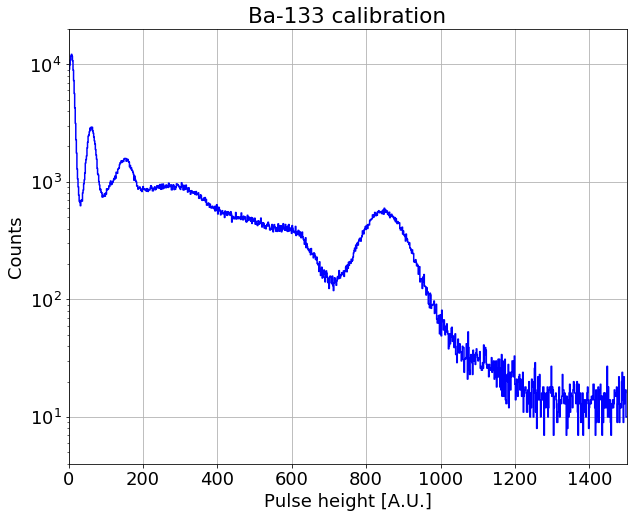

In [30]:
h_pmt_energy = hl.hist( data_pmt['gamma_PH'], bins=np.linspace(0.,1500.,1000) )

hl.plot1d( h_pmt_energy, color='b', label='PMT detector' )
plt.yscale('log')

plt.xlim(0.,1500.)
plt.ylim(4.,2e4)

bincenters = (h_pmt_energy.bins[0][1:] + h_pmt_energy.bins[0][:-1])/2.
binvals = h_pmt_energy.values

plt.xlabel('Pulse height [A.U.]')
plt.ylabel('Counts')
plt.title('Ba-133 calibration')
plt.grid()

In [52]:
def Gaussian( x, A, mu, sig ):
    
    return A * np.exp(-(x-mu)**2/(2*sig**2))



# Define the gamma data for Ba-133
br_356 = 0.6205
br_383 = 0.0894
br_81 = 0.329
br_79 = 0.0265
br_53 = 0.0214
br_35 = 0.0351
br_34 = 0.114 + 0.0588
br_31 = 0.622 + 0.339

e_383 = 383.8485 
e_356 = 356.0129
e_81 = 80.9979
e_79 = 79.6142
e_53 = 53.1622
e_35 = 35.818
e_34 = 34.95
e_31 = 30.8




def FitBa133_356keV( x, A, mu, sig ):
    # This function is intended to fit simultaneously the 356 and 383 keV
    # gamms in the Ba-133 spectrum. It relies on the assumption that, over this
    # short energy range, the response is linear and the resolution for both
    # peaks is the same.
    

    
    return A * (  Gaussian( x, br_356, mu, sig) + \
                    Gaussian( x, br_383, mu*(e_383/e_356), sig ) )




def FitBa133_81keV( x, A, mu, sig ):
    
    return A * ( Gaussian(x, br_81, mu, sig) + \
                    Gaussian( x, br_79, mu*(e_79/e_81), sig) + \
                    Gaussian( x, br_53, mu*(e_53/e_81), sig ) )
    
    

def FitBa133_31keV( x, A, mu, sig ):
    
    return A * ( Gaussian(x, br_31, mu, sig) + \
                    Gaussian( x, br_34, mu*(e_34/e_31), sig) + \
                    Gaussian( x, br_35, mu*(e_35/e_31), sig ) )
    
    
                  

    

In [64]:
# Fit the stuff at 356 keV
fitmask = (bincenters > 750.) & (bincenters < 950.)

p356, cov356 = curve_fit( FitBa133_356keV, bincenters[fitmask], binvals[fitmask], \
                            p0=(900.,850.,50.))



# Fit the 80
fitmask = (bincenters > 120.) & (bincenters < 180.)
p81, cov81 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(1500.,150.,10.))



# Fit the 80
fitmask = (bincenters > 120.) & (bincenters < 180.)
p81, cov81 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(1500.,150.,10.))


# Fit the 31 keV
fitmask = (bincenters > 50.) & (bincenters < 80.)
p31, cov31 = curve_fit( FitBa133_31keV, bincenters[fitmask], binvals[fitmask], \
                             p0=(3000.,60.,10.))




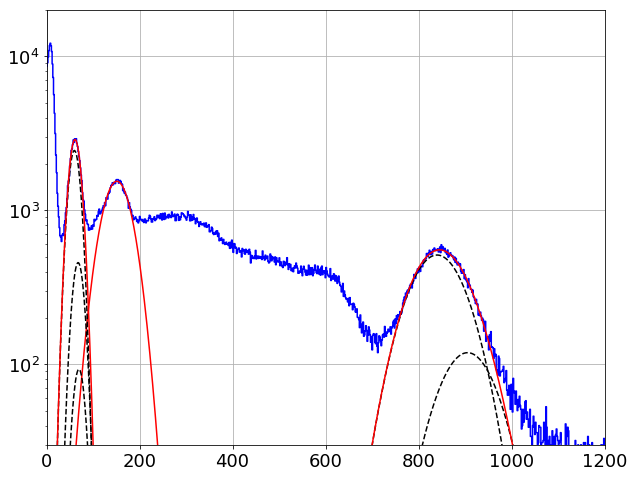

In [65]:


hl.plot1d( h_pmt_energy, color='b', label='PMT detector' )
plt.yscale('log')



# Plot the 356 keV stuff
plt.plot(xfit,Gaussian(xfit, p356[0] * br_356, p356[1], p356[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p356[0] * br_383/br_356, \
                               p356[1]*(e_383/e_356), p356[2] ),'--k')
xfit = np.linspace(0.,1500.,1000)
yfit = FitBa133_356keV( xfit, p356[0], p356[1], p356[2] )
plt.plot(xfit,yfit,'-r')


# # Plot the 81 keV fit
plt.plot( xfit, Gaussian( xfit, p81[0], p81[1], p81[2]), '-r')


# Plot the 31 keV stuff
plt.plot(xfit,Gaussian(xfit, p31[0] * br_31, p31[1], p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_34/br_31, \
                               p31[1]*(e_34/e_31), p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_35/br_31, \
                               p31[1]*(e_35/e_31), p31[2] ),'--k')
yfit = FitBa133_31keV( xfit, p31[0], p31[1], p31[2] )
plt.plot(xfit,yfit,'-r')





plt.xlim(0.,1200.)
plt.ylim(30.,2e4)

plt.grid()

(0.0, 700.0)

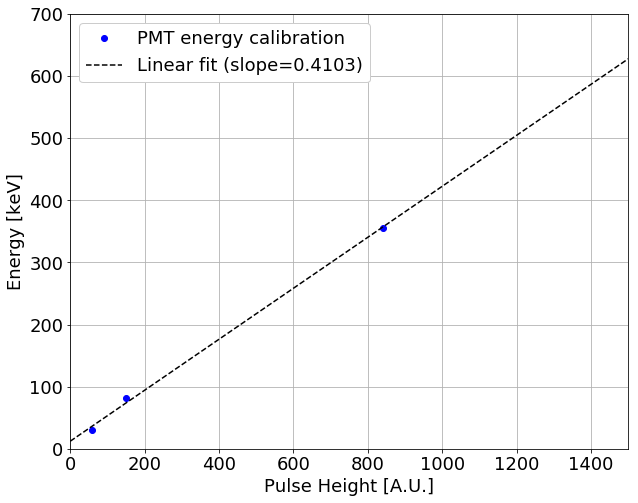

In [67]:
xvals = np.array( [ p31[1], p81[1], p356[1] ] )
energies = np.array( [ e_31, e_81, e_356 ] )

plt.plot(xvals,energies,'ob',label='PMT energy calibration')
plt.xlabel('Pulse Height [A.U.]')
plt.ylabel('Energy [keV]')

ecal_fit = np.polyfit(xvals,energies,1)

plt.plot(xfit,xfit * ecal_fit[0] + ecal_fit[1],'--k',\
         label='Linear fit (slope={:4.4})'.format(ecal_fit[0]))
plt.grid()
plt.legend(framealpha=1)
plt.xlim(0.,1500.)
plt.ylim(0.,700.)


